In [1]:
# data wrangling
import pandas as pd
import numpy as np
# data viz
import matplotlib.pyplot as plt
import seaborn as sns
a4_dims = (11.7, 8.27)
# stats
import math
import scipy.stats as stats
from sklearn import preprocessing

In [2]:
def get_training_data():
    # read data from training dataset
    df = pd.read_csv('train.csv') 
    # convert datetime column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

In [3]:
def get_test_data():
    # read data from training dataset
    df = pd.read_csv('test.csv') 
    # convert datetime column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    return df

In [4]:
bike_sharing_df = get_training_data()
bike_sharing_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test_df = get_test_data()
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


# 1. Data Processing 

### Data Fields

`datetime` datetime : hourly date + timestamp  <br>
`season` int :  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
`holiday` int : whether the day is considered a holiday <br>
`workingday` int : whether the day is neither a weekend nor holiday <br>
`weather` int : <br>
    1 = Clear, Few clouds, Partly cloudy, Partly cloudy <br>
    2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
    3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
    4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
`temp` float : temperature in Celsius<br>
`atemp` float : "feels like" temperature in Celsius<br>
`humidity` int : relative humidity<br>
`windspeed` float : wind speed<br>
`casual` int : number of non-registered user rentals initiated<br>
`registered` int : number of registered user rentals initiated<br>
`count` int : number of total rentals<br>

We would be interested in understanding the timing of rentals better. In order to do so, let us create some further features from the `datetime` column dealing with `hour_of_day`, `day_of_week`, and `month_of_year`.

In [6]:
def get_more_datetime_features(df):
    df['hour_of_day'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.day
    df['month_of_year'] = df['datetime'].dt.month
    print("More datetime features added!")

In order to save some memory, let's convert our `season`, `workingday`, `holiday`, and `weather` into category types. But first, let's translate our integers to more meaningful information.

In [7]:
def cleanup_cat_columns(df):
    print("Cleaning up columns ...")
    df['season'] = df['season'].map(
        {
            1: 'spring', 
            2: 'summer', 
            3: 'fall', 
            4: 'winter'
        }
    )
    df['workingday'] = df['workingday'].map(
        {
            0: "workingday", 
            1: "not_workingday"
        }
    )
    df['holiday'] = df['holiday'].map(
        {
            0: "holiday",
            1: "not_a_holiday"
        }
    )
    df['weather'] = df['weather'].map(
        {
            1: "clear_few_clouds_partly_cloudy",
            2: "mist_cloudy_mist_broken_cloud_mist_few_clouds_mist",
            3: "light_snow_light_rain_thunderstorm_scattered_clouds_light_rain_scattered"
        }
    )
    cat_columns = ['season', 'workingday', 'holiday', 'weather']
    for feature in cat_columns:
        df[feature] = df[feature].astype('category')
    
    print("All clean!")

In [8]:
def add_encoded_columns(df):
    def encode_col(x):
        return preprocessing.LabelEncoder().fit_transform(x)

    # add encoded values for some category columns
    df['season_enc'] = encode_col(df['season'])
    df['holiday_enc'] = encode_col(df['holiday'])
    df['workingday_enc'] = encode_col(df['workingday'])
    print("Enconded columns added!")

We can also add some features like `SMA_3H`, `SMA_12H`, and `SMA_24H`

In [9]:
def get_moving_averages(df):
    print("Calculating SMA features ...")
    df['SMA_3H'] = bike_sharing_df['count'].rolling(window=3).mean()
    df['SMA_12H'] = bike_sharing_df['count'].rolling(window=12).mean()
    df['SMA_24H'] = bike_sharing_df['count'].rolling(window=24).mean()
    print("Done!")

    print("Calculating CMA features ...")
    df['CMA_3H'] = bike_sharing_df['count'].expanding(min_periods=3).mean()
    df['CMA_12H'] = bike_sharing_df['count'].expanding(min_periods=12).mean()
    df['CMA_24H'] = bike_sharing_df['count'].expanding(min_periods=24).mean()
    print("Done!")

In [10]:
def preprocess_data(df):
    print("Starting preprocessing ...")
    get_more_datetime_features(df)
    cleanup_cat_columns(df)
    add_encoded_columns(df)
    get_moving_averages(df)
    print("Preprocessing completed successfully!")

In [11]:
preprocess_data(bike_sharing_df)

Starting preprocessing ...
More datetime features added!
Cleaning up columns ...
All clean!
Enconded columns added!
Calculating SMA features ...
Done!
Calculating CMA features ...
Done!
Preprocessing completed successfully!


In [12]:
bike_sharing_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,month_of_year,season_enc,holiday_enc,workingday_enc,SMA_3H,SMA_12H,SMA_24H,CMA_3H,CMA_12H,CMA_24H
0,2011-01-01 00:00:00,spring,holiday,workingday,clear_few_clouds_partly_cloudy,9.84,14.395,81,0.0,3,...,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,spring,holiday,workingday,clear_few_clouds_partly_cloudy,9.02,13.635,80,0.0,8,...,1,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,spring,holiday,workingday,clear_few_clouds_partly_cloudy,9.02,13.635,80,0.0,5,...,1,1,0,1,29.333333,NaN,NaN,29.333333,NaN,NaN
3,2011-01-01 03:00:00,spring,holiday,workingday,clear_few_clouds_partly_cloudy,9.84,14.395,75,0.0,3,...,1,1,0,1,28.333333,NaN,NaN,25.250000,NaN,NaN
4,2011-01-01 04:00:00,spring,holiday,workingday,clear_few_clouds_partly_cloudy,9.84,14.395,75,0.0,0,...,1,1,0,1,15.333333,NaN,NaN,20.400000,NaN,NaN


In [13]:
# we will now define the features to investigate over
# the course of an exploratory data analysis
FEATURES = [
    "count",
    "casual",
    "registered",
    "season_enc",
    "holiday_enc",
    "workingday_enc",
    "temp",
    "atemp",
    "humidity",
    "windspeed",
    "hour_of_day",
    "day_of_week",
    "month_of_year"
]

We will now remove the outliers in the data

In [14]:
#find absolute value of z-score for each observation
z = np.abs(stats.zscore(bike_sharing_df[FEATURES]))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean = bike_sharing_df[FEATURES][(z<3).all(axis=1)]

print(
    "We removed "
    + str(bike_sharing_df[FEATURES].shape[0] - data_clean.shape[0])
    + " outliers from our data, leaving "
    + str(data_clean.shape[0])
    + " to work with!"
)

We removed 909 outliers from our data, leaving 9977 to work with!


Now we're ready for some **exploratory data analysis**!

Here, we will look to gain as much understanding as possible about our data, and begin thinking about valuable features for our model. We mustn't forget the goal of this analysis: **building a model to predict future bike sharing demand**.

# 2. Exploratory Data Analysis

In [15]:
# add some grouping columns
bike_sharing_df['day'] = bike_sharing_df['datetime'].apply(
    lambda x: x.strftime("%Y-%m")
)
bike_sharing_df['month'] = bike_sharing_df['datetime'].apply(
    lambda x: x.strftime("%Y-%m")
)

First of all, let's have a look at the distribution of our data, and specifically our response variable.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([  1,   1,   1, ..., 968, 970, 977])),
 (169.82942673231383, 191.5741319125482, 0.9372682766213174))

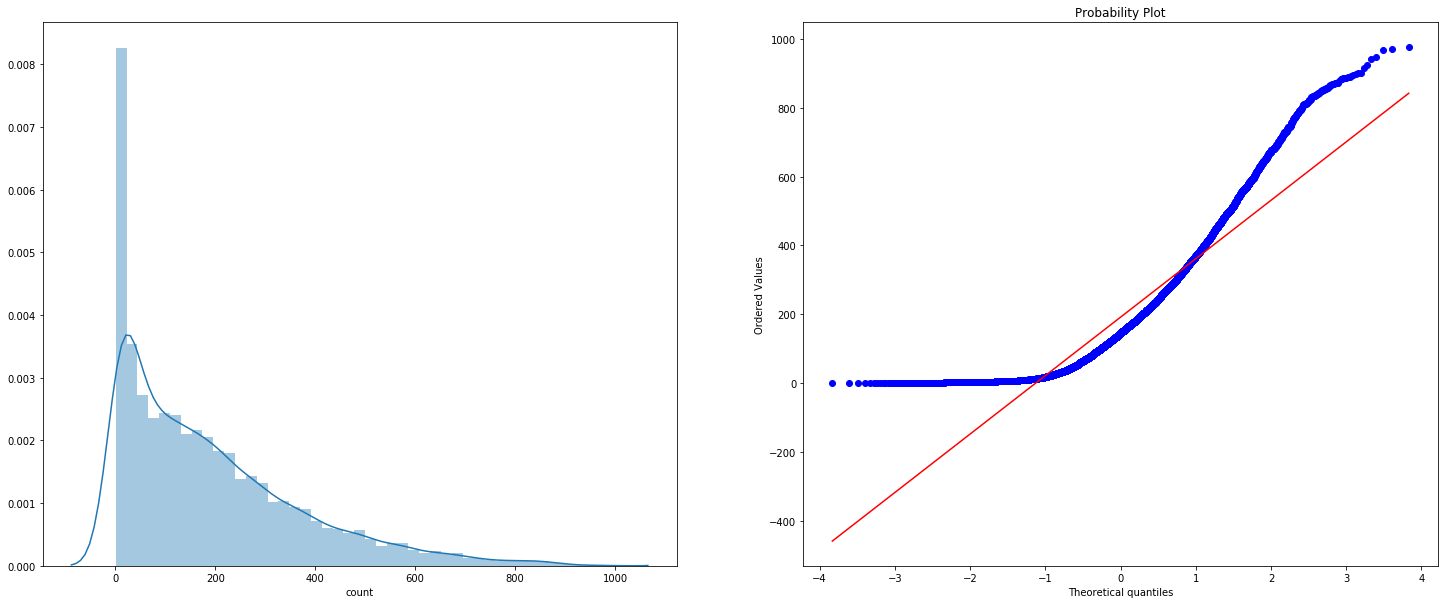

In [16]:
fig, ax = plt.subplots(ncols=2, figsize = (25,10))
sns.distplot(bike_sharing_df["count"],ax=ax[0])
stats.probplot(bike_sharing_df["count"], dist='norm', fit=True, plot=ax[1])

In [17]:
from scipy.stats import shapiro
# normality test
stat, p = shapiro(bike_sharing_df["count"])
print('stat = %.3f\np value = %.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

stat = 0.878
p value = 0.000
Sample does not look Gaussian (reject H0)


/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


We thus have a **non-normally distributed response variable**. Since most of the methods we are interested in are parametric, and these parametric methods require the assumption that the response be normally distributed, we will try and "normalise" our response variable.

One such way, is to apply the [**Box-Cox Transformation**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) and then use a [**Shapiro-Wilks statistic**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html) to test whether the data looks as though it was drawn from a normal distribution.

The Box Cox transformation takes a parameter, lambda (λ), which varies from -5 to 5. All values of λ are considered and the optimal value for your data is selected; The “optimal value” is the one which results in the best approximation of a normal distribution curve. The transformation of Y has the form:

![boxcox](https://www.statisticshowto.com/wp-content/uploads/2015/07/boxcox-formula-1.png)

[Source: [Statistics How To](https://www.statisticshowto.com/box-cox-transformation/)]

The null-hypothesis of the Shapiro-Wilks test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level (we will choose alpha to be 0.05), then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected. [Source: [Wikipedia](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test)]

In [18]:
params = []
boxcox_stats = []

for boxcox_param in np.linspace(-5, 5, 100,endpoint=False):
    print(f"Running Box-Cox transformation with parameter {boxcox_param:.1f} ...")
    bike_sharing_df["count_norm"] = stats.boxcox(bike_sharing_df["count"], boxcox_param)

    # normality test
    stat, p = shapiro(bike_sharing_df["count_norm"])
    # append to lists
    
    params.append(boxcox_param)
    boxcox_stats.append(stat)
    print('stat = %.3f\np value = %.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Normalised data looks Gaussian (fail to reject H0)')
    else:
        print('Normalised data does not look Gaussian (reject H0)')

Running Box-Cox transformation with parameter -5.0 ...
stat = 0.075
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.9 ...
stat = 0.076
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.8 ...
stat = 0.076
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.7 ...
stat = 0.076
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.6 ...
stat = 0.077
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.5 ...
stat = 0.078
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.4 ...
stat = 0.078
p value = 0.000
Normalised data does not look Gaussian (reject H0)
Running Box-Cox transformation with parameter -4.3 ...


Text(0, 0.5, 'Shapiro-Wilks Statistic')

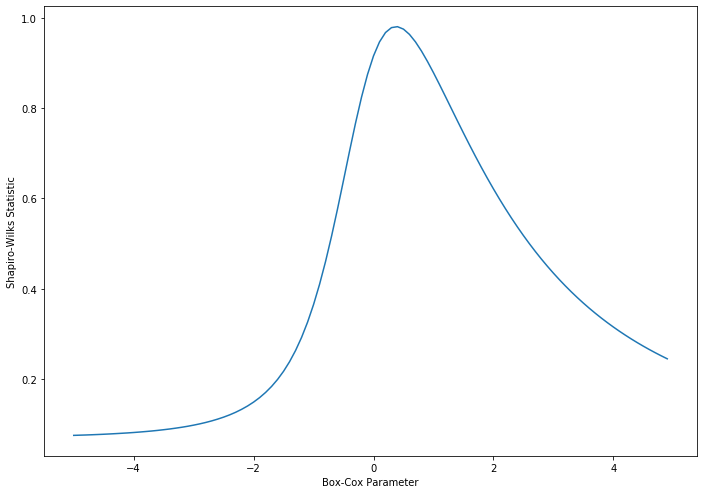

In [19]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x=params, y=boxcox_stats, ax=ax)
ax.set_xlabel("Box-Cox Parameter")
ax.set_ylabel("Shapiro-Wilks Statistic")

We find that the probability with which the data produced by a Box-Cox Transformation with parameter 0.4 was drawn from a normal distribution is 0.98.

Let's check this visually.

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([ 0.        ,  0.        ,  0.        , ..., 36.61021033,
         36.64251281, 36.75525783])),
 (8.228163108409937, 15.371114461635404, 0.9901469962966652))

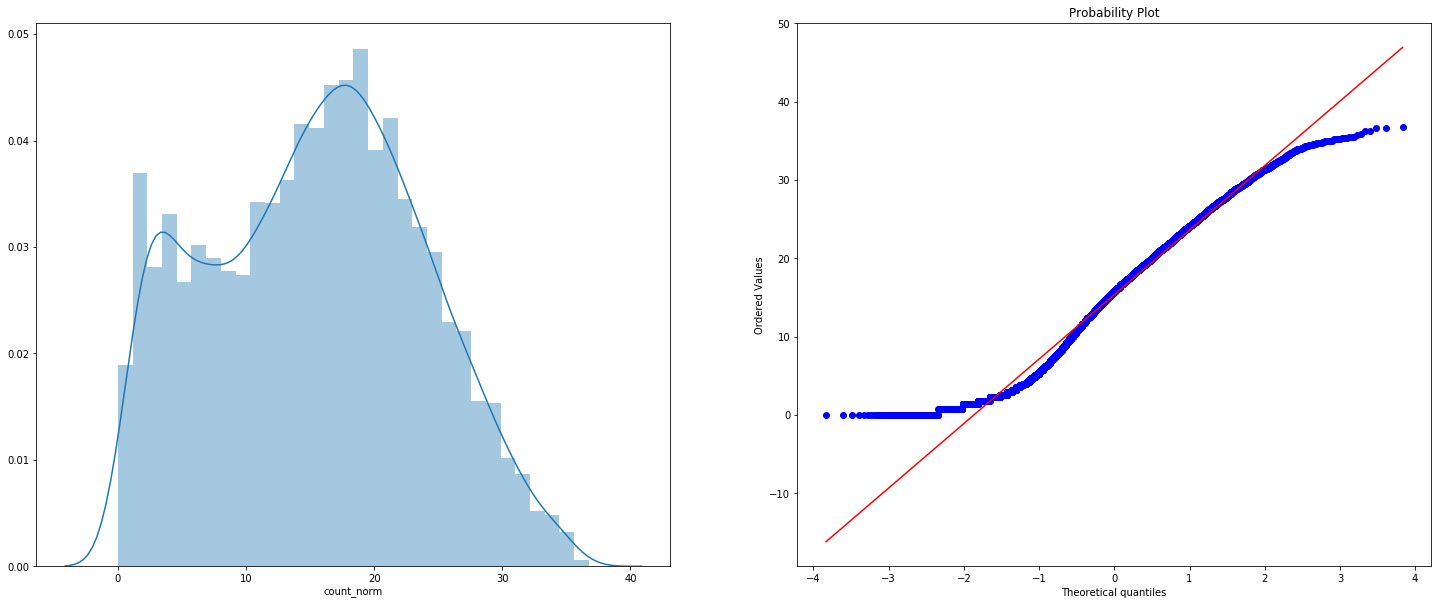

In [20]:
boxcox_param = 0.4
bike_sharing_df["count_norm"] = stats.boxcox(bike_sharing_df["count"], boxcox_param)

fig, ax = plt.subplots(ncols=2, figsize = (25,10))
sns.distplot(bike_sharing_df["count_norm"],ax=ax[0])
stats.probplot(bike_sharing_df["count_norm"], dist='norm', fit=True, plot=ax[1])

Looks good!

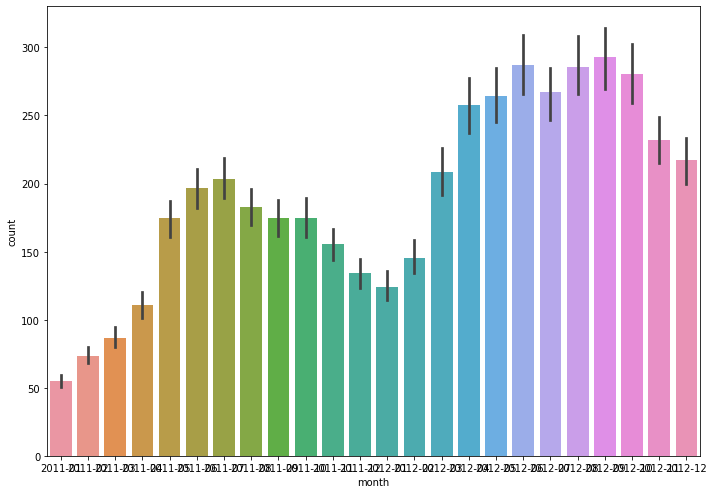

In [21]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(
    ax=ax, 
    data=bike_sharing_df, 
    x='month', 
    y='count'
)

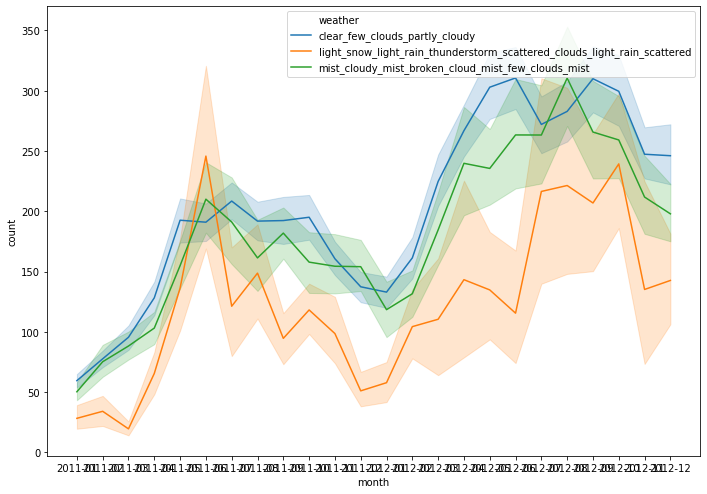

In [22]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    ax=ax, 
    data=bike_sharing_df,
    y='count',
    x='month',
    hue='weather'
)

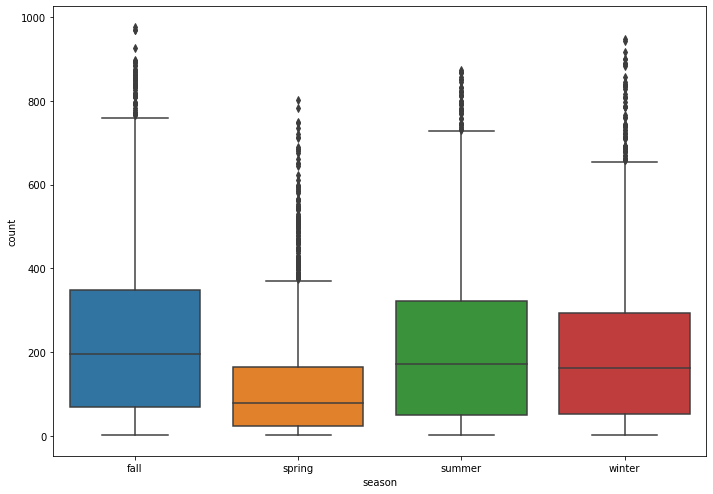

In [23]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='season'
)

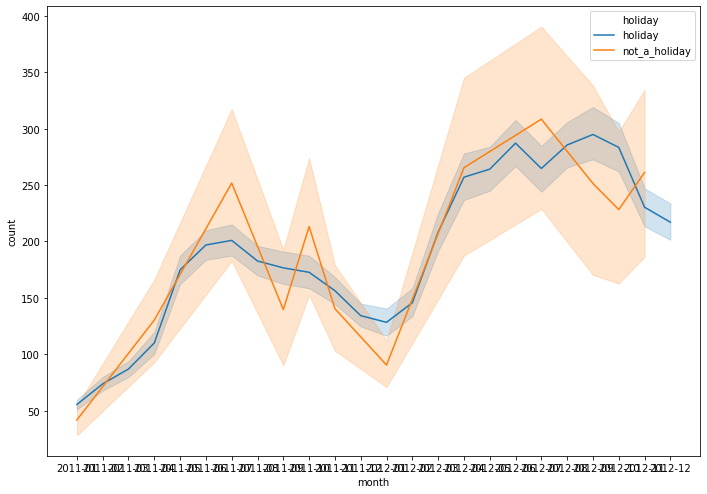

In [24]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    ax=ax, 
    data=bike_sharing_df,
    y='count',
    x='month',
    hue='holiday'
)

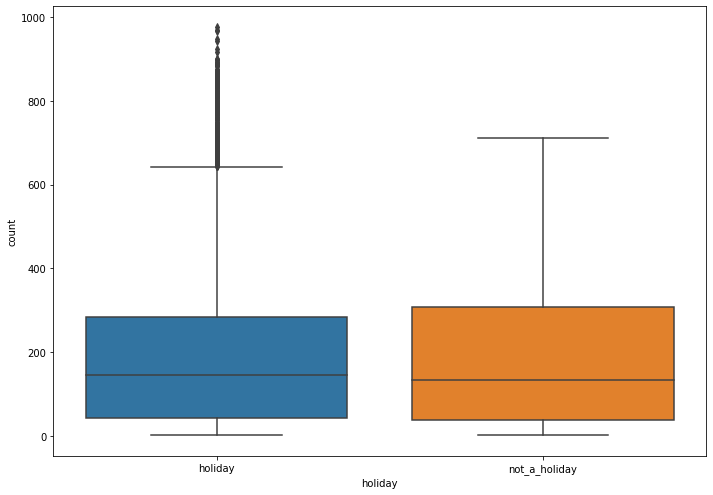

In [25]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='holiday'
)

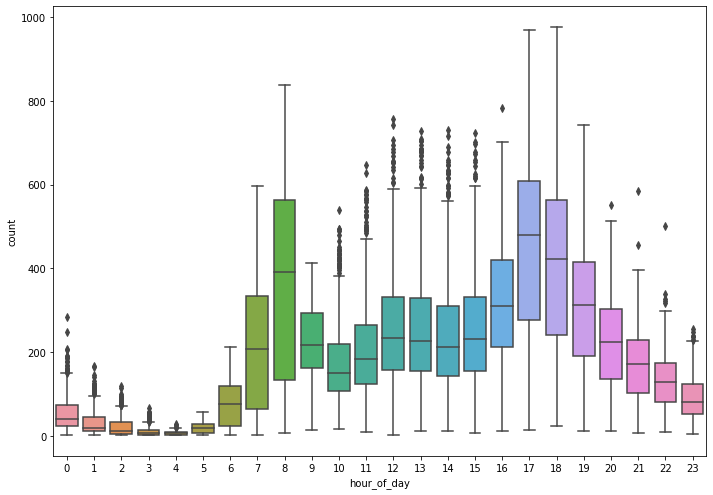

In [26]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='hour_of_day'
)

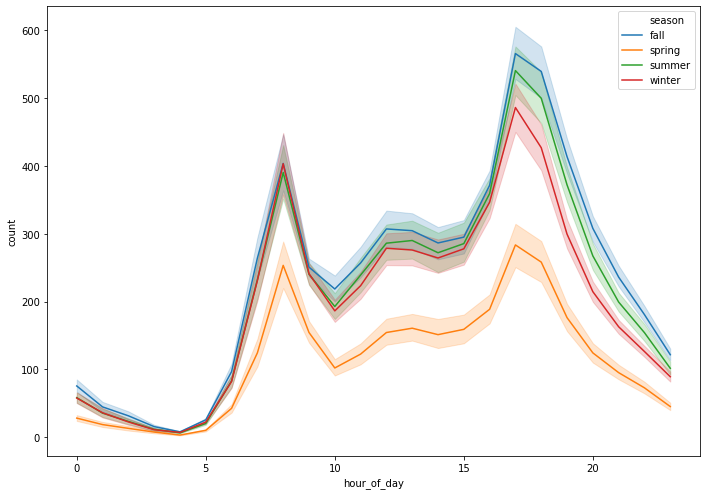

In [27]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='hour_of_day',
    hue='season'
)

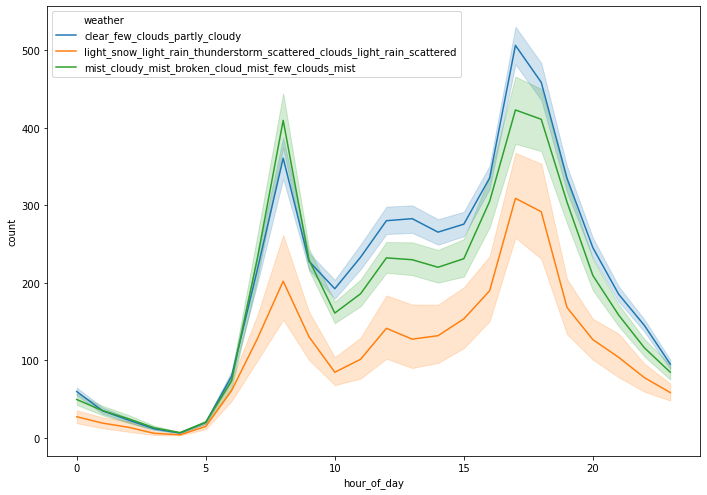

In [28]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='hour_of_day',
    hue='weather'
)

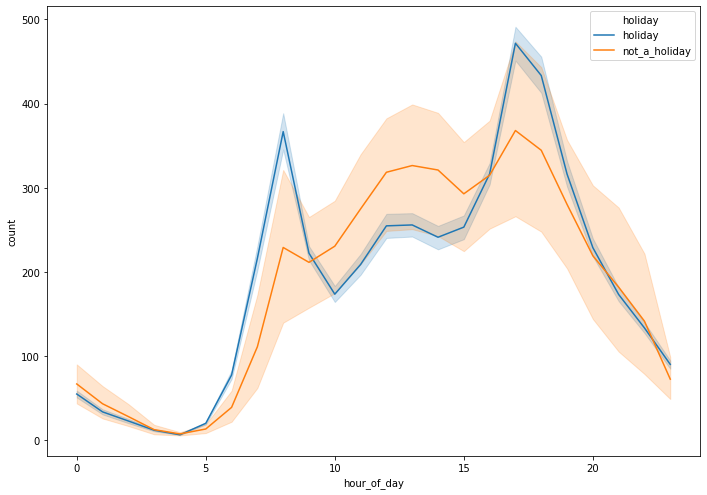

In [29]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='count',
    x='hour_of_day',
    hue='holiday'
)

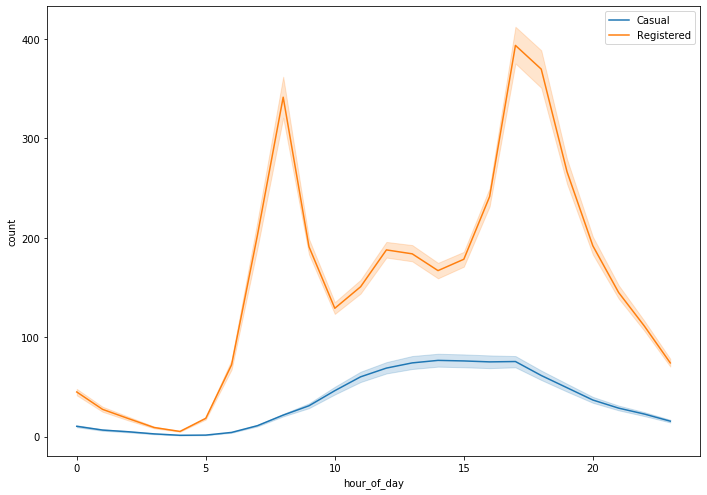

In [30]:
fig, ax = plt.subplots(figsize=a4_dims)
casual_plot = sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='casual',
    x='hour_of_day'
)
casual_plot.set_label("Casual")
registered_plot = sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='registered',
    x='hour_of_day'
)
registered_plot.set_label("Registered")
plt.ylabel("count")
plt.legend(["Casual", "Registered"])
plt.show()

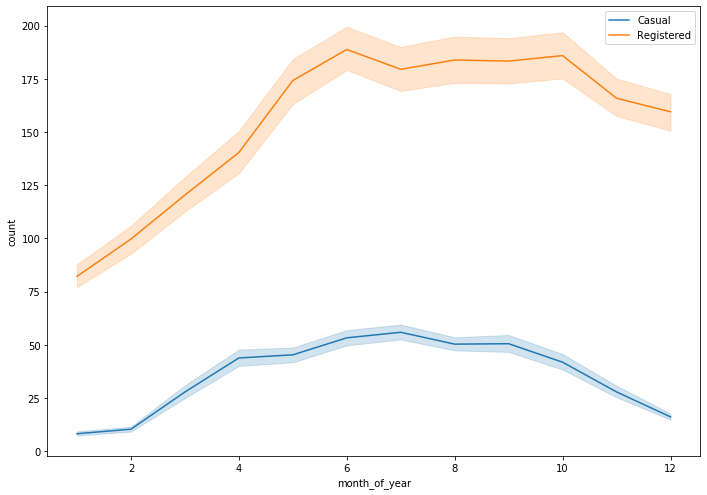

In [31]:
fig, ax = plt.subplots(figsize=a4_dims)
casual_plot = sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='casual',
    x='month_of_year'
)
casual_plot.set_label("Casual")
registered_plot = sns.lineplot(
    ax=ax,
    data=bike_sharing_df,
    y='registered',
    x='month_of_year'
)
registered_plot.set_label("Registered")
plt.ylabel("count")
plt.legend(["Casual", "Registered"])
plt.show()

In [32]:
del bike_sharing_df['day'], bike_sharing_df['month']

In [33]:
def plot_corr_mat(df):
    corr_mat = df[FEATURES].corr()
    mask = np.array(corr_mat)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sns.heatmap(corr_mat, mask=mask,vmax=.8, square=True,annot=True)

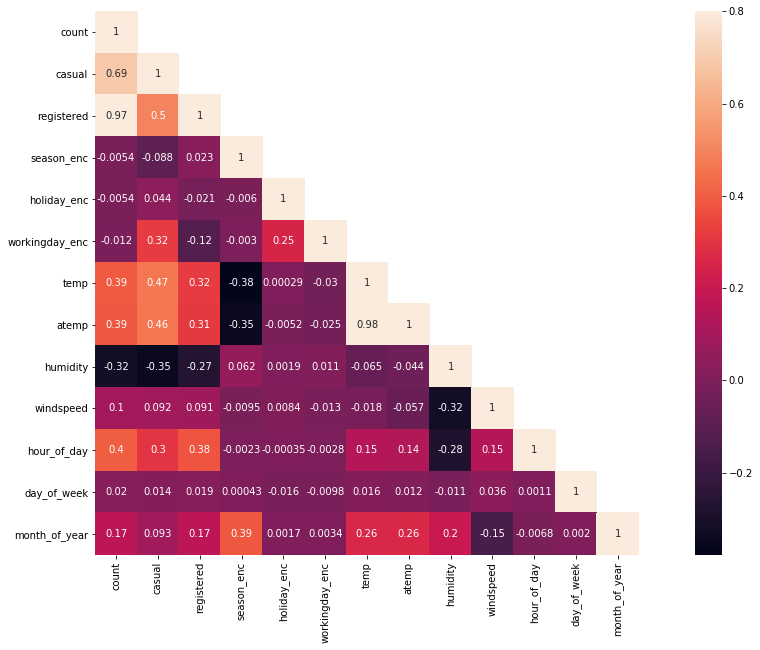

In [34]:
plot_corr_mat(bike_sharing_df)

We note that `count` correlates most strongly (in a linear fashion) with:

- `hour_of_day`
- `month_of_year`
- `temp`
- `atemp`

We can further suppose that there is some sort of seasonality associated with our time series, we will try later to get a better grasp on the extend of the seasonality in our data, and apply our statistical models. For now, let's build a benchmark model!

# 3. Benchmark Model

We will first build an easily interpretable benchmark model to compare our future, more complex models against. The simplest model we can imagine for this is linear regression. Let's first dive deeper into linear regression to make sure we understand the assumptions and motivations.

Assuming that the independent variable is ${\vec {x_{i}}}=[x_{1}^{i},x_{2}^{i},\dots ,x_{m}^{i}]$ and the model's parameters are ${\vec {\beta }}=[\beta _{0},\beta _{1},\cdots ,\beta _{m}]$, then the model's prediction would be $y_{i}\approx \beta _{0}+\sum _{j=1}^{m}\beta _{j}\times x_{j}^{i}$. 

If ${\vec {x_{i}}}$ is extended to ${\vec {x_{i}}}=[1,x_{1}^{i},x_{2}^{i},\dots ,x_{m}^{i}]$ then $y_{i}$ would become a dot product of the parameter and the independent variable, i.e. $y_{i}\approx \sum _{j=0}^{m}\beta _{j}\times x_{j}^{i}={\vec {\beta }}\,\,.\,{\vec {x_{i}}}$. In the least-squares setting, the optimum parameter is defined as such that minimizes the sum of mean squared loss:

$${\vec {\hat {\beta }}}={\underset {\vec {\beta }}{\mbox{arg min}}}\,L(D,{\vec {\beta }})={\underset {\vec {\beta }}{\mbox{arg min}}}\sum _{i=1}^{n}({\vec {\beta }}\,.\,{\vec {x_{i}}}-y_{i})^{2}$$

![loss](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Linear_least_squares_example2.svg/440px-Linear_least_squares_example2.svg.png)

Now putting the independent and dependent variables in matrices $X$ and $Y$ respectively, the loss function can be rewritten as:

$${\begin{aligned}L(D,{\vec {\beta }})&=||X{\vec {\beta }}-Y||^{2}\\&=(X{\vec {\beta }}-Y)^{T}(X{\vec {\beta }}-Y)\\&=Y^{T}Y-Y^{T}X{\vec {\beta }}-{\vec {\beta }}^{T}X^{T}Y+{\vec {\beta }}^{T}X^{T}X{\vec {\beta }}\end{aligned}}
$$

As the loss is convex the optimum solution lies at gradient zero. The gradient of the loss function is (using Denominator layout convention):

$${\begin{aligned}{\frac {\partial L(D,{\vec {\beta }})}{\partial {\vec {\beta }}}}&={\frac {\partial \left(Y^{T}Y-Y^{T}X{\vec {\beta }}-{\vec {\beta }}^{T}X^{T}Y+{\vec {\beta }}^{T}X^{T}X{\vec {\beta }}\right)}{\partial {\vec {\beta }}}}\\&=-2Y^{T}X+2{\vec {\beta }}^{T}X^{T}X\end{aligned}}$$

Setting the gradient to zero produces the optimum parameter:

$${\begin{aligned}-2Y^{T}X+2{\vec {\beta }}^{T}X^{T}X=0\\&\Rightarrow Y^{T}X={\vec {\beta }}^{T}X^{T}X\\&\Rightarrow X^{T}Y=X^{T}X{\vec {\beta }}\\&\Rightarrow {\vec {\hat {\beta }}}=(X^{T}X)^{-1}X^{T}Y\end{aligned}}$$

[Source: [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression)]

## 3.1 Feature Extraction

We will first use **Recursive Feature Extraction (RFE)** to determine how many features our model will need, and then we will use some Ridge and Lasso regressors for **Feature Selection**.

### 3.1.1 Recursive Feature Extraction

[Source: [machinelearningmastery.com](https://machinelearningmastery.com)]

In [35]:
FEATURES.remove("count")
FEATURES.remove("casual")
FEATURES.remove("registered")

In [36]:
X = bike_sharing_df[FEATURES]
y = bike_sharing_df['count_norm']

In [37]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_squared_log_error

The task asks us to us the **Root Mean Square Log Error (RMSLE)** loss function to measure model performance. This follows the following equation:

$$
\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}
$$

This is a non-standard loss function, so we will have to define it ourselves.

RMSLE has a couple of interesting properties:
1. it only cares about the relative difference between truth and prediction
2. it penalises overestimates more than underestimates

Use RMSLE when doing regression, believing that your target, conditioned on the input, is normally distributed, and you don’t want large errors to be significantly more penalized than small ones, in those cases where the range of the target value is large.

[Source: [Peltarion](https://tinyurl.com/y6rhrf93)]

In [138]:
# define our scorer for the model
def rmsle_loss(y_true, y_pred):
    # define root mean squared log error loss funcition
    return np.sqrt(mean_squared_log_error(y_pred, y_true))

rmsle = make_scorer(rmsle_loss, greater_is_better=False)

In [151]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1, len(FEATURES)+1):
        rfe = RFE(estimator=Ridge(alpha=1.0), n_features_to_select=i)
        model = Ridge(alpha=1.0)
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    loss_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_pred = [prediction if prediction > 0 else 0 for prediction in model.predict(X_test)]
        
        loss_scores.append(
            rmsle_loss(
                y_true=y_test, 
                y_pred=y_pred
            )
        )
    return loss_scores

In [152]:
# get models with different numbers of variables
models = get_models()
# evaluate the models and store results
results, names = list(), list()

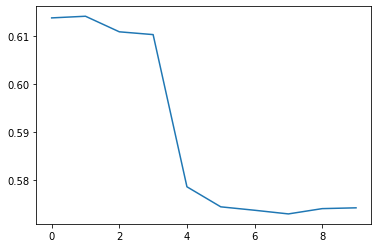

In [153]:
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
# plot model performance for comparison
model_results = [np.mean(model_result) for model_result in results]
plt.plot(model_results)
plt.show()

We can see that adding a fourth feature made the most difference, and that adding more after that didn't improve the model significantly. We will thus identify four features to use for the rest of this analysis.

Let's find those four features.

### 3.1.2. Feature Selection

In [154]:
rfe = RFE(
    estimator=Ridge(
        alpha=1.0,
        copy_X=True,
        fit_intercept=True,
        max_iter=None,
        normalize=False,
        random_state=None,
        solver="auto",
        tol=0.001,
    ),
    n_features_to_select=4,
    step=1,
    verbose=0,
)
rfe.fit(X, y)

RFE(estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
                    normalize=False, random_state=None, solver='auto',
                    tol=0.001),
    n_features_to_select=4, step=1, verbose=0)

In [155]:
print("We will use the following features in our models:\n---")
for i in range(X.shape[1]):
    if rfe.ranking_[i] == 1:
        print(X.columns.values[i])

We will use the following features in our models:
---
season_enc
holiday_enc
temp
hour_of_day


In [201]:
PREDICTIVE_FEATURES = ['season_enc', 'holiday_enc', 'temp', 'hour_of_day']

In [202]:
X = X[PREDICTIVE_FEATURES]

## 3.2 Model Building

In [203]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [204]:
y_pred = [prediction if prediction > 0 else 0 for prediction in reg.predict(X)]

print(
    f"Our linear regression model has a RMSLE of : {rmsle_loss(y_true=y, y_pred=y_pred):.2f}"
)

Our linear regression model has a RMSLE of : 0.56


In [205]:
print(
    f"With coefficients {[round(coef, 2) for coef in reg.coef_]} and intercept {reg.intercept_:.2f}"
)

With coefficients [1.13, -0.13, 0.42, 0.56] and intercept -1.31


Let's see how the model predicted the most recent week of data

In [206]:
last_week_y = y[-168:]
last_week_X = X[-168:]
last_week_pred = reg.predict(last_week_X)

linear_results = pd.DataFrame()
linear_results['datetime'] = bike_sharing_df[-168:]['datetime']
linear_results['true'] = last_week_y
linear_results['pred'] = last_week_pred
linear_results.reset_index(inplace=True)

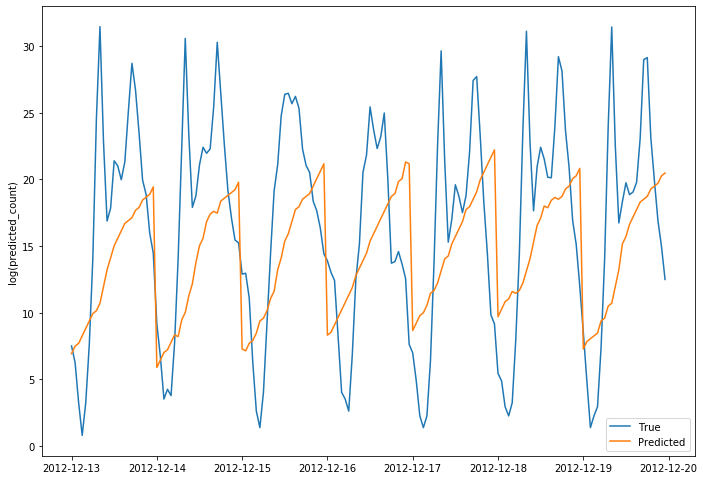

In [207]:
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(
    linear_results['datetime'],
    linear_results['true'], 
    label='True' # true values for the last week
)
plt.plot(
    linear_results['datetime'],
    linear_results['pred'], 
    label='Predicted' # model predictions
)
ax.set_ylabel("datetime")
ax.set_ylabel("log(predicted_count)")
plt.legend()

This benchmark is not entirely accurate, however, the model seems to be able to predict shorter term trends relatively well.

# 4. Tree-based Models

Let's move onto our Machine Learning model choice: **Random Forest**.

This will be a bit more complex, so we will add a subsection to do with model interpretation at the end. Otherwise, we can use the same features as we extracted last section when building a benchmark model.

A random forest is an **ensemble learner**. This means that it makes use of multiple models and learners to increase its performance. In the case of a random forest, these models are decision trees.

Let's first try and understand these base components.

A decision tree splits the data according to some criteria at each node before moving down the tree. The criteria for spliting and hyperparameters. In the case of classification, this is easy to understand.

![decision tree](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmiro.medium.com%2Fmax%2F6810%2F1*1tGLoeGg4cDwQXSLSgD5Zg.png&f=1&nofb=1)

In this toy example, the model predicts an animal's classification based on a set of rules, and eventually returns a class.

In the case of regression, the output is continuous and not discrete. So the decision tree will now return a range of continuous predictions. Let's take another toy example.

![regression tree](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fres.cloudinary.com%2Fdyd911kmh%2Fimage%2Fupload%2Ff_auto%2Cq_auto%3Abest%2Fv1528907338%2Fregression-tree_g8zxq5.png&f=1&nofb=1)

Here, we are looking to predict y given X1 and X2.

The problem with decision trees is that while they are very easy to interpret, they are very sensitive to their training data, so their prediction variances are much higher than other methods.

Ensemble methods combine multiple, independantly trained models to test a single hypothesis, thus eliminating the risk of overfitting data.

The trees in random forests are run in parallel. There is no interaction between these trees while building the trees. The results are then returned, and the average value is taken as the prediction.

![random forest](https://miro.medium.com/max/1400/0*f_qQPFpdofWGLQqc.png)

The training algorithm for random forests applies the general technique of bootstrap aggregating, or bagging, to tree learners. Given a training set $X = x_1, ..., x_n$ with responses $Y = y_1, ..., yn$, bagging repeatedly ($B$ times) selects a random sample with replacement of the training set and fits trees to these samples.

For $b = 1, ..., B$:
1. Sample, with replacement, $n$ training examples from $X$, $Y$; call these $X_b$, $Y_b$.
2. Train a classification or regression tree $f_b$ on $X_b$, $Y_b$.

This reduces the variance. Bagging makes each model run independently and then aggregates the outputs at the end without preference to any model.

**Feature and Advantages of Random Forest :**
1. It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier.
2. It runs efficiently on large databases.
3. It can handle thousands of input variables without variable deletion.
4. It gives estimates of what variables that are important in the classification.
5. It generates an internal unbiased estimate of the generalization error as the forest building progresses.
6. It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.

**Disadvantages of Random Forest :**
1. Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
2. For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.

[Source: [Towards Data Science](https://towardsdatascience.com/random-forest-and-its-implementation-71824ced454f), [Wikipedia](https://en.wikipedia.org/wiki/Random_forest)]

## 4.1 Model Building

In [208]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_jobs=-1)

In [209]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 9, endpoint=False)]

# Create the random grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [210]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator = rfr, 
    param_grid = param_grid, 
    scoring = rmsle,
    cv = 5, 
    n_jobs = -1, 
    verbose = 10
)

In [211]:
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.2s
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elap

{'max_depth': 10, 'n_estimators': 600}

In [217]:
best_rfr = grid_search.best_estimator_

## 4.2 Model Validation

In [218]:
last_week_y = y[-168:]
last_week_X = X[-168:]
last_week_pred = best_rfr.predict(last_week_X)

random_forest_results = pd.DataFrame()
random_forest_results['datetime'] = bike_sharing_df[-168:]['datetime']
random_forest_results['true'] = last_week_y
random_forest_results['pred'] = last_week_pred
random_forest_results.reset_index(inplace=True)

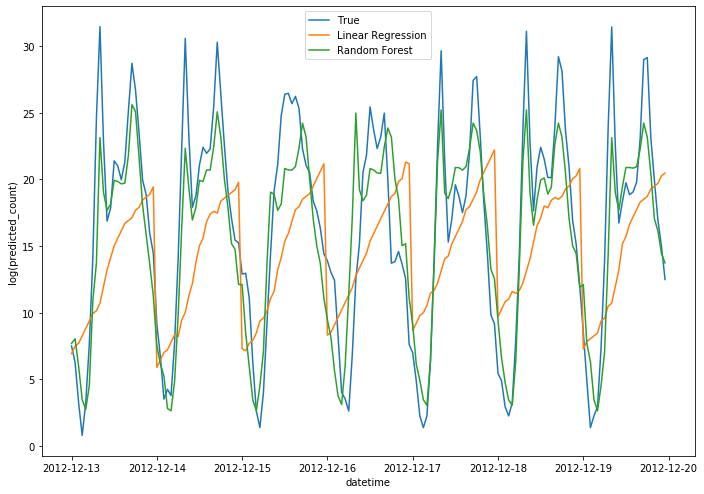

In [219]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    random_forest_results['datetime'], 
    random_forest_results['true'], 
    label='True', # true values for the last week
    ax=ax
)
sns.lineplot(
    linear_results['datetime'],
    linear_results['pred'], 
    label='Linear Regression', # true values for the last week
    ax=ax
)
sns.lineplot(
    random_forest_results['datetime'],
    random_forest_results['pred'], 
    label='Random Forest', # model predictions
    ax=ax
)
ax.set_ylabel("datetime")
ax.set_ylabel("log(predicted_count)")
plt.legend()

In [220]:
kf = KFold(n_splits=5)
loss_scores = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "\tTEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    loss_scores.append(
        rmsle_loss(
            y_true=y_test, 
            y_pred=best_rfr.predict(X_test)
        )
    )

TRAIN: [ 2178  2179  2180 ... 10883 10884 10885] 	TEST: [   0    1    2 ... 2175 2176 2177]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [2178 2179 2180 ... 4352 4353 4354]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [4355 4356 4357 ... 6529 6530 6531]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [6532 6533 6534 ... 8706 8707 8708]
TRAIN: [   0    1    2 ... 8706 8707 8708] 	TEST: [ 8709  8710  8711 ... 10883 10884 10885]


In [221]:
print(
    f"Our random forest regression model has a mean RMSLE of : {np.mean(loss_scores):.2f}"
)

Our random forest regression model has a mean RMSLE of : 0.32


That is an excellent score!

## 4.3. Model Interpretability

In real-life applications, you will have to explain your model to non-technical colleagues. During these interactions, you will have to present your results and potentially justify them. In many cases, if you have chosen a highly complex model, you will have two problems:

1. Stakeholders not understanding what it does
2. You not understanding what it does

If your stakeholders don't understand what your model does, you will have a harder time pitching it. If your pitch isn't effective, stakeholders will be less willing to launch your model into production because they might not want to take on risk without understanding it. If your model doesn't get launched into produciton, then you have wasted your time.

If you don't understand what your model has done, and then down the road you get some weird data (e.g. covid, flash crash, fat finger, ...) which causes your model to fail, then you don't know how to fix it.

The solution: **KISS (keep it simple, stupid)**.

Always go for the simplest model which produces informative results. Or at the very least, understand the model you pitch, and be able to explain it clearly.

We can identify a tradeoff between model interpretability and performance as follows:

![model interpretability](https://raw.githubusercontent.com/cog-data/ML_Interpretability_tutorial/master/img/accuracy_interpretability.png)

Your job as a data scientist is to find the sweet spot.

We have already built a linear regression model and a random forest model, and seen their respective performance. While we can easily understand the linear regression model, the random forest is more difficult.

We will use [**SH**apely **A**dditive ex**P**lanations (SHAP)](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) to gain a deeper understanding of even these blackbox-type models.

SHAP values attribute to each feature the change in the expected model prediction when conditioning on that feature. They explain how to get from the base value the model returns $E[f(\vec{x})]$ that would be predicted if we did not know any features to the current output $f(x_i)$. 

In [222]:
# !pip install shap
import shap
# load JS visualization code to notebook
shap.initjs()

In [223]:
explainer = shap.TreeExplainer(best_rfr)
shap_values = explainer.shap_values(last_week_X)
X_shap = pd.DataFrame(shap_values)

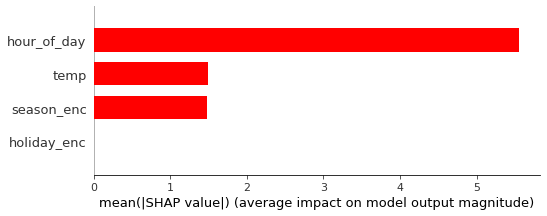

In [224]:
shap.summary_plot(shap_values, last_week_X, plot_type="bar", color='red')

In [225]:
shap.force_plot(explainer.expected_value, shap_values[15,:], last_week_X.iloc[15,:])

In [226]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], last_week_X.iloc[:1000,:])

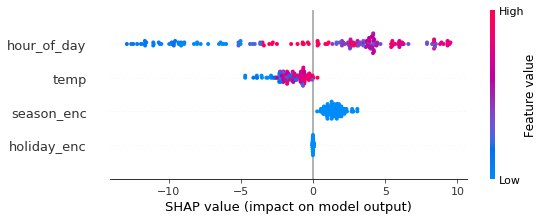

In [227]:
shap.summary_plot(shap_values, last_week_X)

## 4.4. Predicting Casual and Registered Users Independantly (Optional)

We will now try predicting casual and registered users independantly to see if this increasesthe models performance, while mainting interpretability.

In [183]:
casual = bike_sharing_df[bike_sharing_df['casual'] > 0]['casual']
registered = bike_sharing_df[bike_sharing_df['registered'] > 0]['registered']

p-value may not be accurate for N > 5000.


stat = 0.856
p value = 0.000
Sample does not look Gaussian (reject H0)


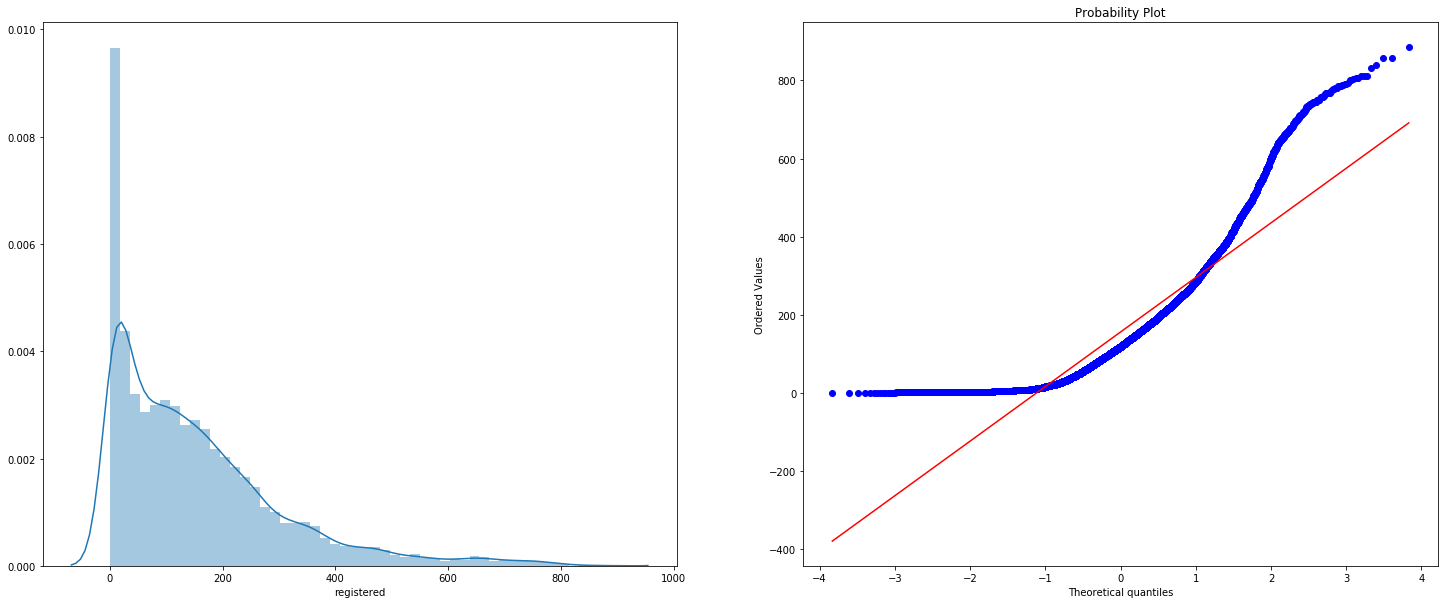

In [184]:
fig, ax = plt.subplots(ncols=2, figsize = (25,10))
sns.distplot(bike_sharing_df['registered'],ax=ax[0])
stats.probplot(bike_sharing_df['registered'], dist='norm', fit=True, plot=ax[1])

from scipy.stats import shapiro
# normality test
stat, p = shapiro(bike_sharing_df["registered"])
print('stat = %.3f\np value = %.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Text(0, 0.5, 'Shapiro-Wilks Statistic')

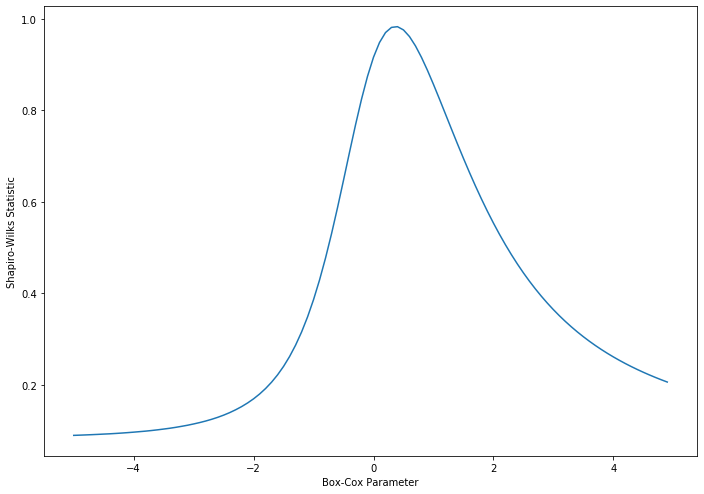

In [185]:
params = []
boxcox_stats = []

for boxcox_param in np.linspace(-5, 5, 100,endpoint=False):
    registered_norm = stats.boxcox(
        registered, boxcox_param
    )

    # normality test
    stat, p = shapiro(registered_norm)
    
    # append to lists
    params.append(boxcox_param)
    boxcox_stats.append(stat)
    
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x=params, y=boxcox_stats, ax=ax)
ax.set_xlabel("Box-Cox Parameter")
ax.set_ylabel("Shapiro-Wilks Statistic")

In [186]:
zipped_stats_params = zip(boxcox_stats, params)
print(
    "We use the Box-Cox parameter : "
    + str(round(max(zipped_stats_params)[1], 2))
)

We use the Box-Cox parameter : 0.4


stat = 0.706
p value = 0.000
Sample does not look Gaussian (reject H0)


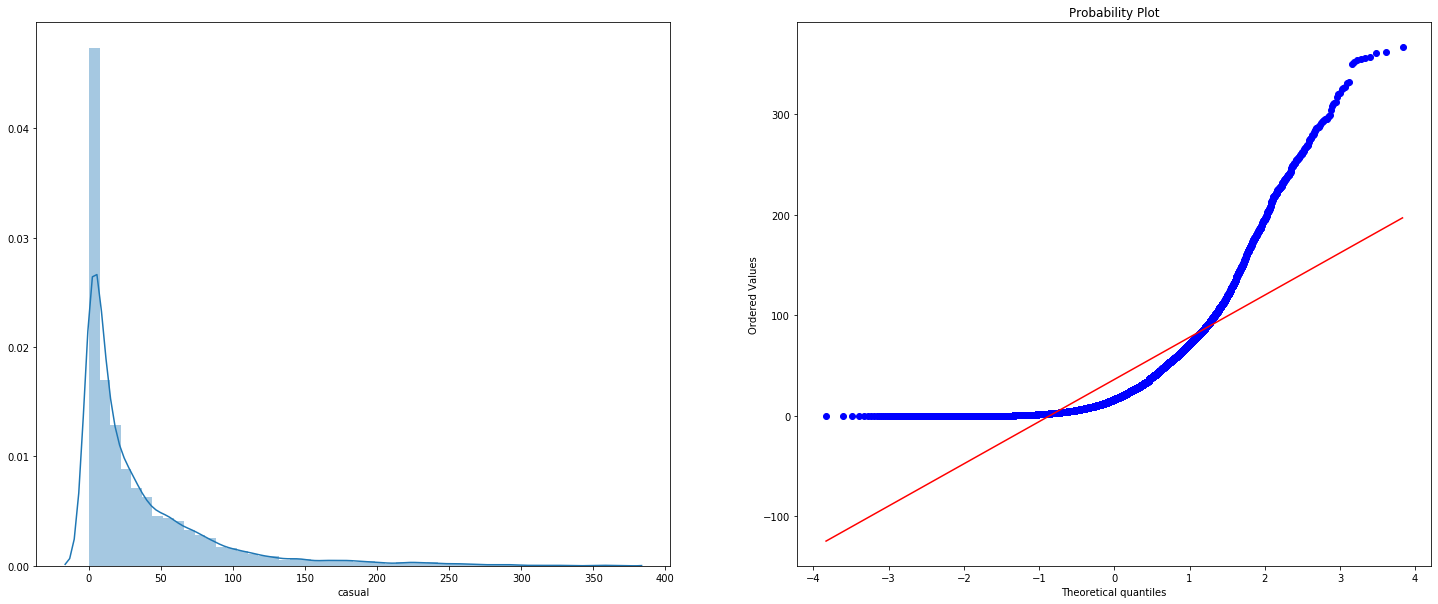

In [187]:
fig, ax = plt.subplots(ncols=2, figsize = (25,10))
sns.distplot(bike_sharing_df['casual'],ax=ax[0])
stats.probplot(bike_sharing_df['casual'], dist='norm', fit=True, plot=ax[1])

from scipy.stats import shapiro
# normality test
stat, p = shapiro(bike_sharing_df["casual"])
print('stat = %.3f\np value = %.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Text(0, 0.5, 'Shapiro-Wilks Statistic')

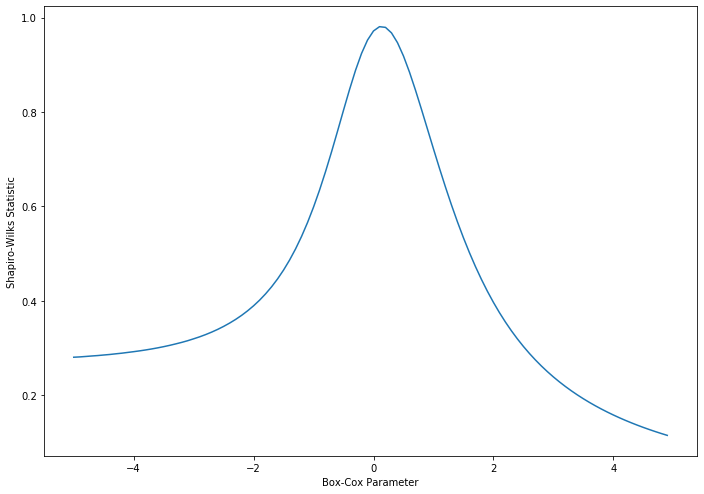

In [188]:
params = []
boxcox_stats = []

for boxcox_param in np.linspace(-5, 5, 100,endpoint=False):
    casual_norm = stats.boxcox(
        casual, boxcox_param
    )

    # normality test
    stat, p = shapiro(casual_norm)
    
    # append to lists
    params.append(boxcox_param)
    boxcox_stats.append(stat)
    
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x=params, y=boxcox_stats, ax=ax)
ax.set_xlabel("Box-Cox Parameter")
ax.set_ylabel("Shapiro-Wilks Statistic")

In [189]:
zipped_stats_params = zip(boxcox_stats, params)
print(
    "We use the Box-Cox parameter : "
    + str(round(max(zipped_stats_params)[1], 2))
)

We use the Box-Cox parameter : 0.1


In [190]:
casual_norm = stats.boxcox(bike_sharing_df['casual']+1, 0.1)
registered_norm = stats.boxcox(bike_sharing_df['registered']+1, 0.4)

In [191]:
rfr_casual = RandomForestRegressor(n_jobs=-1)
casual_grid_search = GridSearchCV(
    estimator = rfr_casual, 
    param_grid = param_grid, 
    scoring = rmsle,
    cv = 5, 
    n_jobs = -1, 
    verbose = 10
)
casual_grid_search.fit(X, casual_norm)

rfr_registered = RandomForestRegressor(n_jobs=-1)
registered_grid_search = GridSearchCV(
    estimator = rfr_registered, 
    param_grid = param_grid, 
    scoring = rmsle,
    cv = 5, 
    n_jobs = -1, 
    verbose = 10
)
registered_grid_search.fit(X, registered_norm)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.5s
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elap

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elap

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 6

In [194]:
last_week_y = y[-168:]
last_week_X = X[-168:]
last_week_pred = (
    casual_grid_search.best_estimator_.predict(last_week_X)
    + registered_grid_search.best_estimator_.predict(last_week_X)
)

multi_forest_results = pd.DataFrame()
multi_forest_results['datetime'] = bike_sharing_df[-168:]['datetime']
multi_forest_results['true'] = last_week_y
multi_forest_results['pred'] = last_week_pred
multi_forest_results.reset_index(inplace=True)

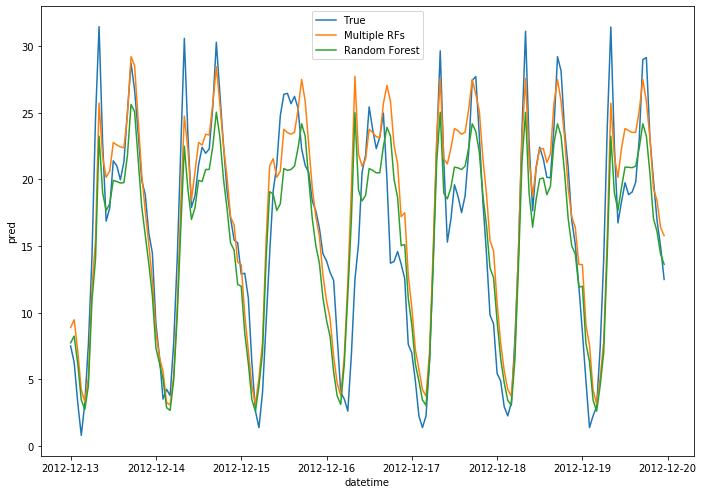

In [195]:
fig, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(
    multi_forest_results['datetime'], 
    multi_forest_results['true'], 
    label='True', # true values for the last week
    ax=ax
)
sns.lineplot(
    multi_forest_results['datetime'],
    multi_forest_results['pred'], 
    label='Multiple RFs', # true values for the last week
    ax=ax
)
sns.lineplot(
    random_forest_results['datetime'],
    random_forest_results['pred'], 
    label='Random Forest', # model predictions
    ax=ax
)
plt.legend()

In [196]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
loss_scores = []

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "\tTEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    loss_scores.append(
        rmsle_loss(
            y_true=y_test, 
            y_pred=(
                casual_grid_search.best_estimator_.predict(X_test)
                + registered_grid_search.best_estimator_.predict(X_test)
            )
        )
    )

TRAIN: [ 2178  2179  2180 ... 10883 10884 10885] 	TEST: [   0    1    2 ... 2175 2176 2177]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [2178 2179 2180 ... 4352 4353 4354]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [4355 4356 4357 ... 6529 6530 6531]
TRAIN: [    0     1     2 ... 10883 10884 10885] 	TEST: [6532 6533 6534 ... 8706 8707 8708]
TRAIN: [   0    1    2 ... 8706 8707 8708] 	TEST: [ 8709  8710  8711 ... 10883 10884 10885]


In [197]:
print(
    f"Our multiple random forest regression model has a mean RMSLE of : {np.mean(loss_scores):.2f}"
)

Our multiple random forest regression model has a mean RMSLE of : 0.36


We notice that our multiple random forest model doesn't out perform our single RF model, and is more complicated so we can't interpret it as easily.

We will use our single RF model to make the final predictions and submit these.

# 5. Making and Submitting Predictions

We complete the task by using our model to predict those data points for which we don't have a true value, and writing our predictions to csv.

In [230]:
from scipy.special import inv_boxcox
preprocess_data(test_df)
print("---\nMaking predictions ...")
predictions = (
    inv_boxcox(best_rfr.predict(test_df[PREDICTIVE_FEATURES]), boxcox_param)
)
print("Predictions made!")

Starting preprocessing ...
More datetime features added!
Cleaning up columns ...
All clean!
Enconded columns added!
Calculating SMA features ...
Done!
Calculating CMA features ...
Done!
Preprocessing completed successfully!
---
Making predictions ...
Predictions made!


In [231]:
predictions_df = pd.DataFrame()
predictions_df['predictions'] = predictions
predictions_df.index = test_df['datetime']

In [232]:
predictions_df.to_csv('predictions.csv')